In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as tf_hub
from PIL import Image

In [2]:
# Download imagenet21k labels
imagenet21k_lemmas_file = Path('download/imagenet21k_wordnet_lemmas.txt')
if not imagenet21k_lemmas_file.is_file():
    !mkdir -p download
    !wget -O download/imagenet21k_wordnet_lemmas.txt https://storage.googleapis.com/bit_models/imagenet21k_wordnet_lemmas.txt

In [3]:
# Load imagenet21k into a indexed map.
d21 = []
with imagenet21k_lemmas_file.open('r') as f21:
    d21 = f21.readlines()

i21 = {i: value.strip('\n') for i, value in enumerate(d21)}

In [4]:
# Download and extract resnet152 model
# resnet152_model_url = "https://tfhub.dev/google/bit/m-r152x4/imagenet21k_classification/1"
resnet152_model_download_url = "https://tfhub.dev/google/bit/m-r152x4/imagenet21k_classification/1?tf-hub-format=compressed"
resnet152_model_dir = Path('download/resnet152_model')
resnet152_model_file = Path('download/resnet152_model.tar.gz')
if not resnet152_model_dir.exists():
    !mkdir -p download
    if not resnet152_model_file.is_file():
        !wget -O "{resnet152_model_file}" "{resnet152_model_download_url}"
    !mkdir -p "{resnet152_model_dir}"
    !tar -xvf "{resnet152_model_file}" -C "{resnet152_model_dir}"

In [5]:
# Load model from disk
resnet152_model = tf_hub.KerasLayer(str(resnet152_model_dir))

2021-10-20 14:49:13.382692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def reshape_image(img):
    img = np.array(img)
    reshaped_img = tf.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]) # [batch, height, width, channels]
    img = tf.image.convert_image_dtype(reshaped_img, tf.float32)
    return img

def show_predictions(model, img, img_dict):
    logits = model(img)
    logits = tf.reshape(logits, [-1])
    probs = tf.nn.softmax(logits)

    t5_idxs = np.argsort(probs)[:-6:-1] # Get indexes of Top 5 probabilities
    t5_probs = np.sort(probs)[:-6:-1]
    t5_labels = [img_dict[i] for i in t5_idxs]

    y_pos = np.flip(np.arange(len(t5_labels)))
    plt.barh(y_pos, t5_probs, color='blue')
    for i, v in zip(y_pos, t5_probs):
        plt.text(x=max(0.05, v-0.3), y=i-0.15, s=round(v,2), color='black', size=15, wrap=True)
    plt.yticks(y_pos, t5_labels)
    plt.title('Top 5 Predictions')

def predict_image(img_file):
    img = Image.open(img_file).convert("RGB")
    shaped_img = reshape_image(img)
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    show_predictions(resnet152_model, tf.image.resize(shaped_img, (224, 224)), i21)
    plt.subplot(1,2,2)
    plt.imshow(shaped_img[0])
    plt.tight_layout()

2021-10-20 14:50:02.852663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


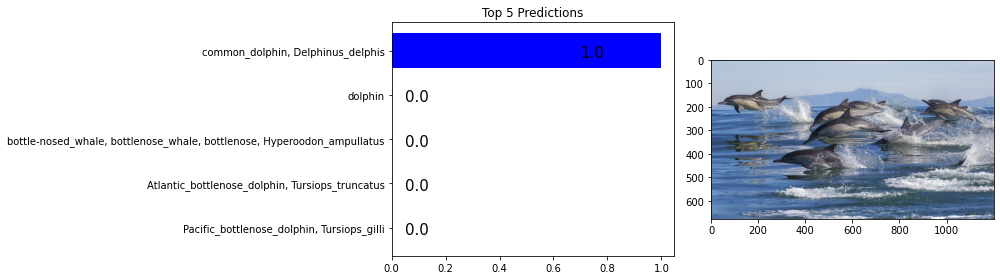

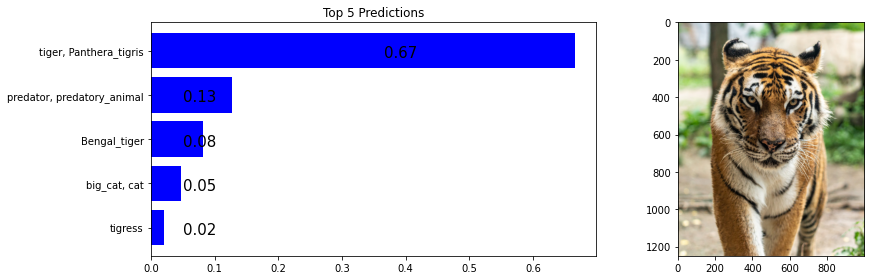

In [7]:
predict_image("data/dolphins.jpeg")
predict_image("data/tiger.jpeg")